In [19]:
from stable_baselines3 import PPO
import numpy as np
import sys
sys.path.append("..")
from simulation import simulate_policy
from evaluation.evaluator import Evaluator
from tqdm import trange
import matplotlib.pyplot as plt

In [20]:
import config

exp = 2

config.customers_types = ['seasonal', 'recurring']
config.customer_mix = [0,1]
config.competitor = False

In [21]:
market = "du" if config.competitor else "mon"
model0 = PPO.load(f"../../src/results_final/0{exp}_0-10_{market}opoly/model.zip")
model1 = PPO.load(f"../../src/results_final/0{exp}_1-9_{market}opoly/model.zip")
model2 = PPO.load(f"../../src/results_final/0{exp}_2-8_{market}opoly/model.zip")
model3 = PPO.load(f"../../src/results_final/0{exp}_3-7_{market}opoly/model.zip")
model4 = PPO.load(f"../../src/results_final/0{exp}_4-6_{market}opoly/model.zip")
model5 = PPO.load(f"../../src/results_final/0{exp}_5-5_{market}opoly/model.zip")
model6 = PPO.load(f"../../src/results_final/0{exp}_6-4_{market}opoly/model.zip")
model7 = PPO.load(f"../../src/results_final/0{exp}_7-3_{market}opoly/model.zip")
model8 = PPO.load(f"../../src/results_final/0{exp}_8-2_{market}opoly/model.zip")
model9 = PPO.load(f"../../src/results_final/0{exp}_9-1_{market}opoly/model.zip")
model10 = PPO.load(f"../../src/results_final/01_{market}opoly/model.zip")

models = [model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10]

In [22]:
f_mono_sales_price = {customer_type: [] for customer_type in config.customers_types}
f_mono_sales = {customer_type: [] for customer_type in config.customers_types}

In [23]:
for i, model in enumerate(models):

    config.customer_mix = [i/10, (10-i)/10]


    ## Agent
    # Per Customer Type
    n_buys = {customer_type: [] for customer_type in config.customers_types}
    reward = {customer_type: [] for customer_type in config.customers_types}
    sales_price = {customer_type: [] for customer_type in config.customers_types}
    # Total
    total_sales_price = []
    total_reward = []
    total_buys = []
    ## Competitor
    # Per Customer Type
    comp_n_buys = {customer_type: [] for customer_type in config.customers_types}
    comp_reward = {customer_type: [] for customer_type in config.customers_types}
    comp_sales_price = {customer_type: [] for customer_type in config.customers_types}
    # Total
    comp_total_sales_price = []
    comp_total_reward = []
    comp_total_buys = []

    for _ in trange(100): #config.n_eval_episodes
        infos = simulate_policy(model, deterministic=True)
        infos = {key: value[config.episode_length // 2:] for key, value in infos.items()}

        infos = Evaluator().add_concatenated_infos(infos)

        i_reward = 0
        i_n_buys = 0

        comp_i_reward = 0
        comp_i_n_buys = 0

        for customer_type in config.customers_types:
            n_buys[customer_type].append(np.sum(infos[f'n_{customer_type}_buy']))
            reward[customer_type].append(np.sum(infos[f'{customer_type}_reward']))
            sales_price[customer_type].append(reward[customer_type][-1] / n_buys[customer_type][-1])

            i_reward += reward[customer_type][-1]
            i_n_buys += n_buys[customer_type][-1]

            if config.competitor:
                comp_n_buys[customer_type].append(np.sum(infos[f'n_{customer_type}_competitor_buy']))
                comp_reward[customer_type].append(np.sum(infos[f'{customer_type}_competitor_reward']))
                comp_sales_price[customer_type].append(comp_reward[customer_type][-1] / comp_n_buys[customer_type][-1])

                comp_i_reward += comp_reward[customer_type][-1]
                comp_i_n_buys += comp_n_buys[customer_type][-1]

        
        total_buys.append(i_n_buys)
        total_sales_price.append(i_reward / i_n_buys)

        if config.competitor:
            comp_total_buys.append(comp_i_n_buys)
            comp_total_sales_price.append(comp_i_reward / comp_i_n_buys)
    
    if config.competitor:
        for customer_type in config.customers_types:
            total_n_buys = np.mean(np.add(n_buys[customer_type], comp_n_buys[customer_type]))
            total_reward = np.mean(np.add(reward[customer_type], comp_reward[customer_type]))
            f_mono_sales_price[customer_type].append(total_reward / total_n_buys)
            f_mono_sales[customer_type].append(total_n_buys)
    else:
        for customer_type in config.customers_types:
            f_mono_sales_price[customer_type].append(np.mean(sales_price[customer_type]))
            f_mono_sales[customer_type].append(np.mean(n_buys[customer_type]))

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/1p/fkcycksx2zx597fz2zfd5_gw0000gn/T/ipykernel_3749/463149107.py:40: RuntimeWarning: invalid value encountered in scalar divide
  sales_price[customer_type].append(reward[customer_type][-1] / n_buys[customer_type][-1])
100%|██████████| 100/100 [00:01<00:00, 67.18it/s]


In [24]:
f_mono_sales['seasonal'] = [n_buys/i for i, n_buys in enumerate(f_mono_sales['seasonal'])]
f_mono_sales[config.customers_types[1]] = [n_buys/(10-i) for i, n_buys in enumerate(f_mono_sales[config.customers_types[1]])]

/var/folders/1p/fkcycksx2zx597fz2zfd5_gw0000gn/T/ipykernel_3749/3760597575.py:1: RuntimeWarning: invalid value encountered in scalar divide
  f_mono_sales['seasonal'] = [n_buys/i for i, n_buys in enumerate(f_mono_sales['seasonal'])]
/var/folders/1p/fkcycksx2zx597fz2zfd5_gw0000gn/T/ipykernel_3749/3760597575.py:2: RuntimeWarning: invalid value encountered in scalar divide
  f_mono_sales[config.customers_types[1]] = [n_buys/(10-i) for i, n_buys in enumerate(f_mono_sales[config.customers_types[1]])]


In [25]:
config.competitor = True
market = "du" if config.competitor else "mon"
model0 = PPO.load(f"../../src/results_final/0{exp}_0-10_{market}opoly/model.zip")
model1 = PPO.load(f"../../src/results_final/0{exp}_1-9_{market}opoly/model.zip")
model2 = PPO.load(f"../../src/results_final/0{exp}_2-8_{market}opoly/model.zip")
model3 = PPO.load(f"../../src/results_final/0{exp}_3-7_{market}opoly/model.zip")
model4 = PPO.load(f"../../src/results_final/0{exp}_4-6_{market}opoly/model.zip")
model5 = PPO.load(f"../../src/results_final/0{exp}_5-5_{market}opoly/model.zip")
model6 = PPO.load(f"../../src/results_final/0{exp}_6-4_{market}opoly/model.zip")
model7 = PPO.load(f"../../src/results_final/0{exp}_7-3_{market}opoly/model.zip")
model8 = PPO.load(f"../../src/results_final/0{exp}_8-2_{market}opoly/model.zip")
model9 = PPO.load(f"../../src/results_final/0{exp}_9-1_{market}opoly/model.zip")
model10 = PPO.load(f"../../src/results_final/01_{market}opoly/model.zip")

models = [model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10]

f_duo_agent_price = {customer_type: [] for customer_type in config.customers_types}
f_duo_agent_sales = {customer_type: [] for customer_type in config.customers_types}

f_duo_comp_price = {customer_type: [] for customer_type in config.customers_types}
f_duo_comp_sales = {customer_type: [] for customer_type in config.customers_types}

f_duo_sales_price = {customer_type: [] for customer_type in config.customers_types}
f_duo_sales = {customer_type: [] for customer_type in config.customers_types}

for i, model in enumerate(models):

    config.customer_mix = [i/10, (10-i)/10]


    ## Agent
    # Per Customer Type
    n_buys = {customer_type: [] for customer_type in config.customers_types}
    reward = {customer_type: [] for customer_type in config.customers_types}
    sales_price = {customer_type: [] for customer_type in config.customers_types}
    # Total
    total_sales_price = []
    total_reward = []
    total_buys = []
    ## Competitor
    # Per Customer Type
    comp_n_buys = {customer_type: [] for customer_type in config.customers_types}
    comp_reward = {customer_type: [] for customer_type in config.customers_types}
    comp_sales_price = {customer_type: [] for customer_type in config.customers_types}
    # Total
    comp_total_sales_price = []
    comp_total_reward = []
    comp_total_buys = []

    for _ in trange(100): #config.n_eval_episodes
        infos = simulate_policy(model)
        infos = {key: value[config.episode_length // 2:] for key, value in infos.items()}

        infos = Evaluator().add_concatenated_infos(infos)

        i_reward = 0
        i_n_buys = 0

        comp_i_reward = 0
        comp_i_n_buys = 0

        for customer_type in config.customers_types:
            n_buys[customer_type].append(np.sum(infos[f'n_{customer_type}_buy']))
            reward[customer_type].append(np.sum(infos[f'{customer_type}_reward']))
            sales_price[customer_type].append(reward[customer_type][-1] / n_buys[customer_type][-1])

            i_reward += reward[customer_type][-1]
            i_n_buys += n_buys[customer_type][-1]

            if config.competitor:
                comp_n_buys[customer_type].append(np.sum(infos[f'n_{customer_type}_competitor_buy']))
                comp_reward[customer_type].append(np.sum(infos[f'{customer_type}_competitor_reward']))
                comp_sales_price[customer_type].append(comp_reward[customer_type][-1] / comp_n_buys[customer_type][-1])

                comp_i_reward += comp_reward[customer_type][-1]
                comp_i_n_buys += comp_n_buys[customer_type][-1]

        
        total_buys.append(i_n_buys)
        total_sales_price.append(i_reward / i_n_buys)

        if config.competitor:
            comp_total_buys.append(comp_i_n_buys)
            comp_total_sales_price.append(comp_i_reward / comp_i_n_buys)
    
    for customer_type in config.customers_types:
        f_duo_agent_price[customer_type].append(np.mean(sales_price[customer_type]))
        f_duo_agent_sales[customer_type].append(np.mean(n_buys[customer_type]))
        f_duo_comp_price[customer_type].append(np.mean(comp_sales_price[customer_type]))
        f_duo_comp_sales[customer_type].append(np.mean(comp_n_buys[customer_type]))
        total_n_buys = np.mean(np.add(n_buys[customer_type], comp_n_buys[customer_type]))
        total_reward = np.mean(np.add(reward[customer_type], comp_reward[customer_type]))
        f_duo_sales_price[customer_type].append(total_reward / total_n_buys)
        f_duo_sales[customer_type].append(total_n_buys)



f_duo_agent_sales['seasonal'] = [n_buys/i for i, n_buys in enumerate(f_duo_agent_sales['seasonal'])]
f_duo_agent_sales[config.customers_types[1]] = [n_buys/(10-i) for i, n_buys in enumerate(f_duo_agent_sales[config.customers_types[1]])]

f_duo_comp_sales['seasonal'] = [n_buys/i for i, n_buys in enumerate(f_duo_comp_sales['seasonal'])]
f_duo_comp_sales[config.customers_types[1]] = [n_buys/(10-i) for i, n_buys in enumerate(f_duo_comp_sales[config.customers_types[1]])]

f_duo_sales['seasonal'] = [n_buys/i for i, n_buys in enumerate(f_duo_sales['seasonal'])]
f_duo_sales[config.customers_types[1]] = [n_buys/(10-i) for i, n_buys in enumerate(f_duo_sales[config.customers_types[1]])]

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/1p/fkcycksx2zx597fz2zfd5_gw0000gn/T/ipykernel_3749/3527861450.py:65: RuntimeWarning: invalid value encountered in scalar divide
  sales_price[customer_type].append(reward[customer_type][-1] / n_buys[customer_type][-1])
/var/folders/1p/fkcycksx2zx597fz2zfd5_gw0000gn/T/ipykernel_3749/3527861450.py:73: RuntimeWarning: invalid value encountered in scalar divide
  comp_sales_price[customer_type].append(comp_reward[customer_type][-1] / comp_n_buys[customer_type][-1])
100%|██████████| 100/100 [00:02<00:00, 43.36it/s]
/var/folders/1p/fkcycksx2zx597fz2zfd5_gw0000gn/T/ipykernel_3749/3527861450.py:93: RuntimeWarning: invalid value encountered in scalar divide
  f_duo_sales_price[customer_type].append(total_reward / total_n_buys)
100%|██████████| 100/100 [00:02<00:00, 45.96it/s]
/var/folders/1p/fkcycksx2zx597fz2zfd5_gw0000gn/T/ipykernel_3749/3527861450.py:98: RuntimeWarning: invalid value encountered in scalar divide
  f_duo_agent_sales['seasonal

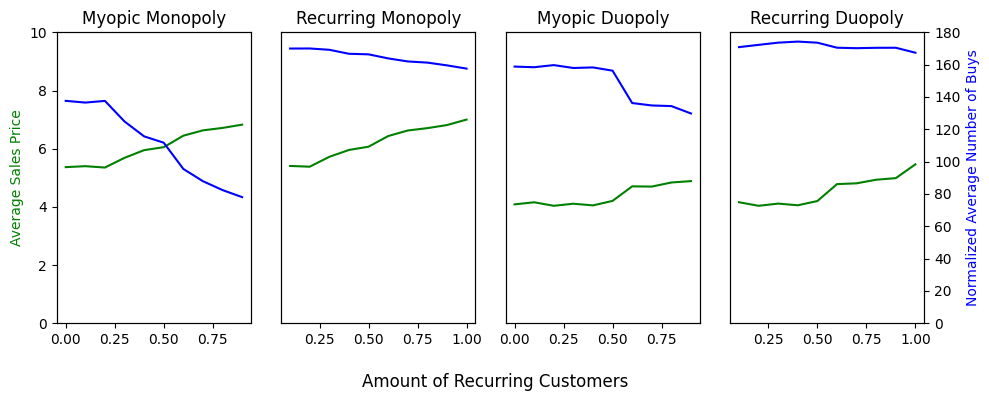

In [27]:
x = np.arange(0, 1.1, 0.1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(10,4))
ax1_b = ax1.twinx()

ax1.plot(x[:-1], np.nan_to_num(np.flip(f_mono_sales_price['seasonal'][1:])), 'g-')
ax1_b.plot(x[:-1], np.nan_to_num(np.flip(f_mono_sales['seasonal'][1:])), 'b-')

ax1.set_ylabel('Average Sales Price', color='g')

ax2_b = ax2.twinx()

ax2.plot(x[1:], np.nan_to_num(np.flip(f_mono_sales_price[config.customers_types[1]][:-1])), 'g-')
ax2_b.plot(x[1:], np.nan_to_num(np.flip(f_mono_sales[config.customers_types[1]][:-1])), 'b-')

ax3_b = ax3.twinx()

ax3.plot(x[:-1], np.nan_to_num(np.flip(f_duo_sales_price['seasonal'][1:])), 'g-')
ax3_b.plot(x[:-1], np.nan_to_num(np.flip(f_duo_sales['seasonal'][1:])), 'b-')

#ax3.plot(x[:-1], np.nan_to_num(np.flip(f_duo_agent_price['seasonal'][1:])), 'g--')
#ax3_b.plot(x[:-1], np.nan_to_num(np.flip(f_duo_agent_sales['seasonal'][1:])), 'b--')

#ax3.plot(x[:-1], np.nan_to_num(np.flip(f_duo_comp_price['seasonal'][1:])), 'r--')
#ax3_b.plot(x[:-1], np.nan_to_num(np.flip(f_duo_comp_sales['seasonal'][1:])), 'r-')

ax4_b = ax4.twinx()

ax4.plot(x[1:], np.nan_to_num(np.flip(f_duo_sales_price[config.customers_types[1]][:-1])), 'g-')
ax4_b.plot(x[1:], np.nan_to_num(np.flip(f_duo_sales[config.customers_types[1]][:-1])), 'b-')

#ax4.plot(x[1:], np.nan_to_num(np.flip(f_duo_agent_price[config.customers_types[1]][:-1])), 'g--')
#ax4_b.plot(x[1:], np.nan_to_num(np.flip(f_duo_agent_sales[config.customers_types[1]][:-1])), 'b--')

# ax4.plot(x[1:], np.nan_to_num(np.flip(f_duo_comp_price[config.customers_types[1]][:-1])), 'r-')
# ax4_b.plot(x[1:], np.nan_to_num(np.flip(f_duo_comp_sales[config.customers_types[1]][:-1])), 'r--')

ax4_b.set_ylabel('Normalized Average Number of Buys', color='b')

ax1.set_ylim(bottom=0, top=10)
ax2.set_ylim(bottom=0, top=10)

ax1_b.set_ylim(bottom=0, top=180)
ax2_b.set_ylim(bottom=0, top=180)
ax3_b.set_ylim(bottom=0, top=180)
ax4_b.set_ylim(bottom=0, top=180)

ax1.set_title("Myopic Monopoly")
ax2.set_title("Recurring Monopoly")
ax3.set_title("Myopic Duopoly")
ax4.set_title("Recurring Duopoly")

ax1_b.tick_params(right=False, labelright=False)
ax2_b.tick_params(right=False, labelright=False)
ax3_b.tick_params(right=False, labelright=False)
ax2.tick_params(left=False, labelleft=False)
ax3.tick_params(left=False, labelleft=False)
ax4.tick_params(left=False, labelleft=False)

fig.supxlabel('Amount of Recurring Customers')

plt.tight_layout()
#plt.show()
plt.savefig("e2_sensitivity")